# Classifying handwritten digits

Let's take a short break from the theory and see a neural network in action.

  > Readings
  > * Chapter 6, Deep Feedforward Networks, Deep Learning, I. Goodfellow, Y. Bengio, and A. Courville, MIT Press, 2016.
  > * Pattern Recognition and Machine Learning, C. M. Bishop and others, Volume 1. Springer New York, 2006.

We will implement and train our first multilayer neural network to classify handwritten digits from the popular **Mixed National Institute of Standards and Technology (MNIST)** dataset that has been constructed by Yann LeCun and others, and serves as a popular benchmark dataset for machine learning algorithms.

## Obtaining the MNIST dataset

The MNIST dataset is publicly available at [MNIST](http://yann.lecun.com/exdb/mnist/) and consists of the following four parts:

  * Training set images: train-images-idx3-ubyte.gz
  * Training set labels: train-labels-idx1-ubyte.gz
  * Test set images: t10k-images-idx3-ubyte.gz
  * Test set labels: t10k-labels-idx1-ubyte.gz

In [1]:
# %load load_mnist.py
import os
import struct
import numpy as np


def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels),
                                                              784)
        images = ((images / 255.) - .5) * 2

    return images, labels

The `load_mnist` function returns two arrays, the first being an $n \times m$ dimensional NumPy array (images), where $n$ is the number of samples and $m$ is the number of features (here, pixels).

By executing the following code, we will now load the 60,000 training instances as well as the 10,000 test samples from the local directory where we unzipped the MNIST dataset (in the following code snippet, it is assumed that the downloaded MNIST files were unzipped to the same directory in which this code was executed):

In [2]:
X_train, y_train = load_mnist('datasets/', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('datasets/', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 60000, columns: 784
Rows: 10000, columns: 784


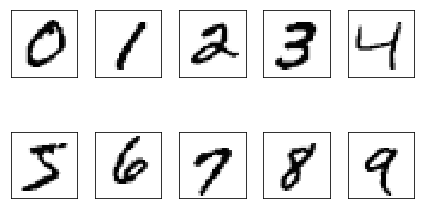

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5,
                      sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

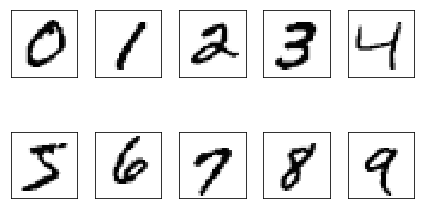

In [11]:
# showing a representative image
fig, ax = plt.subplots(nrows=2,
                      ncols=5,
                      sharex=True,
                      sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [12]:
!mkdir savez_data

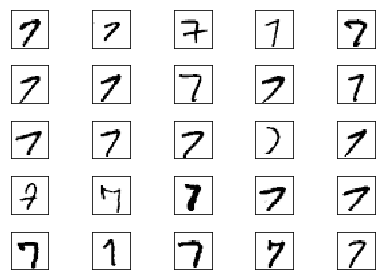

In [14]:
#  plot multiple examples of the same digit
fig, ax = plt.subplots(nrows=5,
                      ncols=5,
                      sharex=True,
                      sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

After we've gone through all the previous steps, it is a good idea to save the scaled images in a format that we can load more quickly into a new Python session to avoid the overhead of reading in and processing the data again. When we are working with NumPy arrays, an efficient yet most convenient method to save multidimensional arrays to disk is NumPy's `savez` function. In short, the `savez` function is analogous to Python's pickle.

The following code snippet will save both the training and test datasets to the archive file `mnist_scaled.npz`:

In [15]:
# save data into savez_compressed files.
import numpy as np

np.savez_compressed('savez_data/mnist_scaled.npz',
                   X_train=X_train,
                   y_train=y_train,
                   X_test=X_test,
                   y_test=y_test)

In [16]:
!ls savez_data

mnist_scaled.npz


In [17]:
# we can load the preprocessed MNIST image arrays using NumPy's load function as follows:
mnist = np.load('savez_data/mnist_scaled.npz')

In [18]:
# The mnist variable now references to an object that can access the four data arrays 
mnist.files

['X_train', 'y_train', 'X_test', 'y_test']

In [19]:
# to load the training data into our current Python session,
# we will access the 'X_train' array as follows (similar to a Python dictionary)
X_train = mnist['X_train']
X_train

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

In [20]:
# Using a list comprehension, we can retrieve all four data arrays as follows
X_train, y_train, X_test, y_test = [mnist[f] for f in mnist.files]

We will now implement the code of an MLP with one input, one hidden, and one output layers to classify the images in the MNIST dataset. The code will contain parts that we have not talked about yet, such as the backpropagation algorithm, but most of the code should look familiar to you based on the Adaline implementation.

Do not worry if not all of the code makes immediate sense to you; we will follow up on certain parts later. However, going over the code at this stage can make it easier to follow the theory later.

In [21]:
import numpy as np
import sys

class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.
    
    Parameters
    -------------
    n_hidden : int (default: 30)
        Number of hidden units.
    l2 : float (default: 0)
        Lambda value for L2-regularization.
        No regularization if l2=0. (default)
    epochs : int (default: 100)
        Number of passes over the training set.
    eta : float (default: 0.001)
        Learning rate.
    shuffle: bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
    minibatch_size : int (default 1)
        Number of training sampels per minibatch.
    seed : int (default: None)
        Random seed for initalizing weights and shuffling.
        
    Attributes
    ------------
    eval_ : dict
        Dictionary collecting the cost, training accuracy,
        and validation accuracy for each epoch during training.
    """
    def __init__(self, n_hidden=30,
                l2=0., epochs=100, eta=0.001,
                shuffle=True, minibatch_size=1, seed=None):
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
        
    def _onehot(self, y, n_classes):
        """Encode labels into one-hot representation
        
        Parameters
        ------------
        y : array, shape = [n_sampels]
            Target values.
            
        Returns
        ------------
        onehot: array, shape = (n_samples, n_labels)
        """
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T
    
    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    
    def _forward(self, X):
        """Compute forward propagation step"""
        
        # step 1: net input of hidden layer
        # [n_samples, n_features] dot [n_features, n_hidden]
        # -> [n_samples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h
        
        # step 2: activation of hidden layer
        a_h = self._sigmoid(z_h)
        
        # step 3: net input of output layer
        # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_samples, n_classlabels]
        z_out = np.dot(a_h, self.w_out) + self.b_out
        
        # step 4: activation output layer
        a_out = self._sigmoid(z_out)
        
        return z_h, a_h, z_out, a_out
    
    def _compute_cost(self, y_enc, output):
        """Compute cost function.
        
        Parameters
        ------------
        y_enc : array, shape = (n_samples, n_labels)
            one-hot encoded class labels.
        output :  array, shape = [n_samples, n_output_units]
            Activation of the output layer (forward propagation)
            
        Returns:
        ------------
        cost : float
            Regularized cost
            
        """
        L2_term = (self.l2 *
                   (np.sum(self.w_h ** 2.) +
                   np.sum(self.w_out ** 2.)))
        
        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term
        
        # If you are applying this cost function to other
        # datasets where activation
        # values maybe become more extreme (closer to zero or 1)
        # you may encounter "ZeroDivisionError"s due to numerical
        # instabilities in Python & NumPy for the current implementation.
        # I.e., the code tries to evaluate log(0), which is undefined.
        # To address this issue, you could add a small constant to the
        # activation values that are passed to the log function.
        #
        # For example:
        #
        # term1 = -y_enc * (np.log(output + 1e-5))
        # term2 = (1. - y_enc) * np.log(1. - output + 1e-5)
        
        return cost
    
    def predict(self, X):
        """Predict class labels
        
        Parameters
        ------------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.
            
        Returns:
        ------------
        y_pred : array, shape = [n_samples]
            Predicted class labels.
            
        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred
    
    def fit(self, X_train, y_train, X_valid, y_valid):
        """Learn weights from training data.
        
        Parameters
        ------------
        X_train : array, shape = [n_samples, n_feaures]
            Input layer with original features.
        y_train : array, shape = [n_samples]
            Target class labels.
        X_valid : array, shape = [n_samples, n_features]
            Sample features for validation during training
        y_valid : array, shape = [n_samples]
            Sample labels for validation during training
            
        Returns:
        ----------
        self
        """
        n_output = np.unique(y_train).shape[0]  # number of class labels
        n_features = X_train.shape[1]
        
        #######################
        # Weiht initialization
        #######################
        
        # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                     size=(n_features, self.n_hidden))
        
        # weights for hidden -> output
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                       size=(self.n_hidden, n_output))
        
        epoch_strlen = len(str(self.epochs))  # for progress formatting
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}
        
        y_train_enc = self._onehot(y_train, n_output)
        
        # iterate over training epochs
        for i in range(self.epochs):
            
            # iterate over minibatches
            indices = np.arange(X_train.shape[0])
            
            if self.shuffle:
                self.random.shuffle(indices)
                
            for start_idx in range(0, indices.shape[0] - self.minibatch_size +
                                  1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]
                
                # forward propagation
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])
                
                #######################
                # Backpropagation
                #######################
                
                # [n_samples, n_classlabels]
                sigma_out = a_out - y_train_enc[batch_idx]
                
                # [n_samples, h_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)
                
                # [n_samples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_samples, n_hidden]
                sigma_h = (np.dot(sigma_out, self.w_out.T) * 
                          sigmoid_derivative_h)
                
                # [n_features, n_samples] dot [n_samples, n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
                grad_b_h = np.sum(sigma_h, axis=0)
                
                # [n_hidden, n_samples] dot [n_samples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, sigma_out)
                grad_b_out = np.sum(sigma_out, axis=0)
                
                # Regularization and weight updates
                delta_w_h = (grad_w_h + self.l2 * self.w_h)
                delta_b_h = grad_b_h  # bias is no regularized
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h
                
                delta_w_out = (grad_w_out + self.l2 * self.w_out)
                delta_b_out = grad_b_out  # bias is not regularized
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out
                
            #############
            # Evaluation
            #############
            
            # Evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)
            cost = self._compute_cost(y_enc=y_train_enc,
                                     output=a_out)
            
            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)
            
            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
                        X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) /
                        X_valid.shape[0])
            
            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                            '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                            (epoch_strlen, i+1, self.epochs, cost,
                            train_acc*100, valid_acc*100))
            sys.stderr.flush()
            
            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)
            
        return self

Let's now initialize a new 784-100-10 MLP—a neural network with 784 input units (n_features), 100 hidden units (n_hidden), and 10 output units (n_output):

In [22]:
nn = NeuralNetMLP(n_hidden=100,
                 l2=0.01,
                 epochs=200,
                 eta=0.0005,
                 minibatch_size=100,
                 shuffle=True,
                 seed=1)

Next, we train the MLP using 55,000 samples from the already shuffled MNIST training dataset and use the remaining 5,000 samples for validation during training. Note that training the neural network may take up to 5 minutes on standard desktop computer hardware.

As you may have noticed from the preceding code implementation, we implemented the `fit` method so that it takes four input arguments: training images, training labels, validation images, and validation labels. In neural network training, it is really useful to already compare training and validation accuracy during training, which helps us judge whether the network model performs well, given the architecture and hyperparameters.

In general, training (deep) neural networks is relatively expensive compared with the other models we discussed so far. Thus, we want to stop it early in certain circumstances and start over with different hyperparameter settings. Alternatively, if we find that it increasingly tends to overfit the training data (noticeable by an increasing gap between training and validation set performance), we may want to stop the training early as well.

Now, to start the training, we execute the following code:

In [23]:
nn.fit(X_train=X_train[:55000],
      y_train=y_train[:55000],
      X_valid=X_train[55000:],
      y_valid=y_train[55000:])

200/200 | Cost: 5065.78 | Train/Valid Acc.: 99.28%/97.98% 

In our `NeuralNetMLP` implementation, we also defined an `eval_` attribute that collects the cost, training, and validation accuracy for each epoch so that we can visualize the results using Matplotlib:

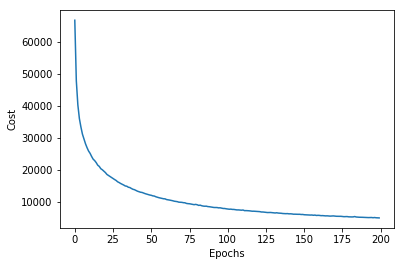

In [24]:
import matplotlib.pyplot as plt

plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.show()

As we can see, the cost decreased substantially during the first 100 epochs and seems to slowly converge in the last 100 epochs. However, the small slope between epoch 175 and epoch 200 indicates that the cost would further decrease with a training over additional epochs.

Next, let's take a look at the training and validation accuracy:

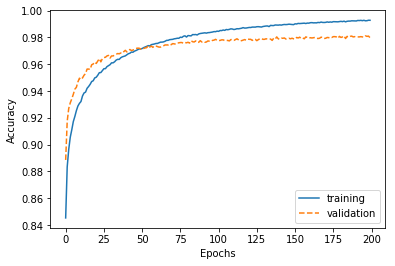

In [25]:
plt.plot(range(nn.epochs), nn.eval_['train_acc'],
        label='training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'],
        label='validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

The plot reveals that the gap between training and validation accuracy increases the more epochs we train the network. At approximately the 50th epoch, the training and validation accuracy values are equal, and then, the network starts overfitting the training data.

Finally, let's evaluate the generalization performance of the model by calculating the prediction accuracy on the test set:

In [26]:
y_test_pred = nn.predict(X_test)

acc = (np.sum(y_test == y_test_pred)
      .astype(np.float) / X_test.shape[0])
print('Training accuracy: %.2f%%' % (acc * 100))

Training accuracy: 97.54%


Despite the slight overfitting on the training data, our relatively simple one-hidden layer neural network achieved a relatively good performance on the test dataset, similar to the validation set accuracy (97.98 percent).

Lastly, let's take a look at some of the images that our MLP struggles with:

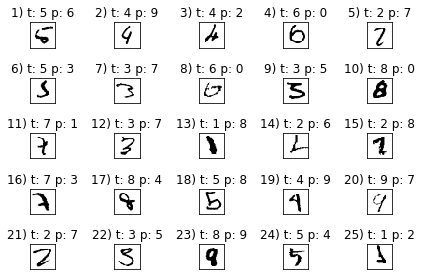

In [27]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5,
                      ncols=5,
                      sharex=True,
                      sharey=True)

ax = ax.flatten()

for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img,
                cmap='Greys',
                interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d'
                   % (i+1, correct_lab[i], miscl_lab[i]))
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()